In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import statsmodels.formula.api as smf
import math
import statsmodels.formula.api as sm

In [136]:
data = pd.read_csv('data.csv', sep=';')

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check
*By Yide Cui*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [137]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [138]:
data.y.value_counts()

no     3668
yes     451
Name: y, dtype: int64

Text(0.5, 1.0, 'Has the client subscribed a term deposit?')

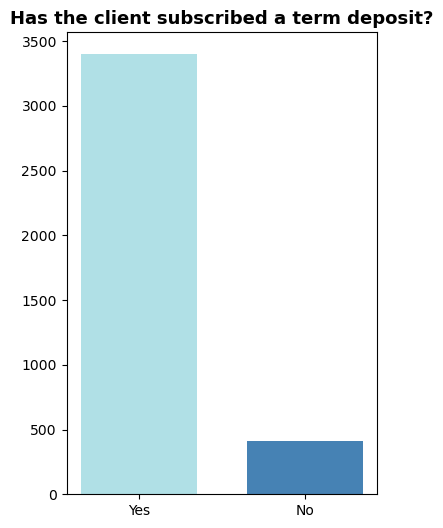

In [139]:
Subscription = {'Yes':3398, 'No':413}
YN = list(Subscription.keys())
Counts = list(Subscription.values())
  
fig = plt.figure(figsize = (4, 6))

# creating the bar plot
plt.bar(YN, Counts, color = ['powderblue', 'steelblue'], width = 0.7)
 
plt.title("Has the client subscribed a term deposit?",fontdict={'fontsize': '13', 'fontweight' : 'bold'})

### Data cleaning
*By Yide Cui*

From the data quality check we realized that:

1. Some of the columns that should have contained only numeric values, specifically <>, <>, and <> have special characters such as \*, #, %. We'll remove these characters, and convert the datatype of these columns to numeric.

2. Some of the columns have more than 60% missing values, and it is very difficult to impute their values, as the values seem to be missing at random with negligible association with other predictors. We'll remove such columns from the data.

3. The column `number_of_bedrooms` has some unreasonably high values such as 15. As our data consist of single-family homes in Evanston, we suspect that any value greater than 5 may be incorrect. We'll replace all values that are greater than 5 with an estimate obtained using the $K$-nearest neighbor approach.

4. The columns `house_price` has some unreasonably high values. We'll tag all values greater than 1 billion dollars as "potentially incorrect observation", to see if they distort our prediction / inference later on.

The code below implements the above cleaning.

In [140]:
data['education']=data['education'].replace('unknown',np.NaN)
data['marital']=data['marital'].replace('unknown',np.NaN)
data['housing']=data['housing'].replace('unknown',np.NaN)
data['loan']=data['loan'].replace('unknown',np.NaN)
data['job']=data['job'].replace('unknown',np.NaN)

data.drop(['default'], axis=1, inplace = True)
data.dropna(axis=0, inplace=True)

### Data preparation
*By Yide Cui*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have shuffled the dataset to prepare it for K-fold cross validation.

3. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [141]:
## Binning the catogorical Data
data['education'] = data['education'].apply(lambda x:'Primary' if 'basic' in x else 'Primary' if 'illiterate' in x else 'Secondary' if 'high.school' in x else 'Secondary' if 'professional.course' in x else 'Tertiary' if 'university.degree' in x else x)
data['job'] = data['job'].apply(lambda x:'Employed' if 'admin.' in x else 'Employed' if 'blue-collar' in x else 'Employed' if 'technician' in x else 'Employed' if 'services' in x else 'Employed' if 'management' in x else 'Employed' if 'self-employed' in x else 'Employed' if 'entrepreneur' in x else 'Unemployed' if 'retired' in x else 'Unemployed' if 'unemployed' in x else 'Unemployed' if 'housemaid' in x else 'Unemployed' if 'student' in x else x)
data['marital'] = data['marital'].apply(lambda x:'single' if 'divorce' in x else x)
data['poutcome_modified'] = data['poutcome'].apply(lambda x:'failure' if 'nonexistent' in x else x)

In [142]:
data['y_dum']= data['y'].map({'no': 0, 'yes': 1})

In [143]:
data.drop(['y'], axis=1, inplace = True)

In [144]:
data['poutcome_success'] = data['poutcome'].map({'failure': 0, 'success': 1})

In [145]:
## Rename the column
data = data.rename(columns={'emp.var.rate': 'emp_var_rate', 'cons.price.idx': 'cons_price_idx', 'cons.conf.idx': 'cons_conf_idx', 'nr.employed': 'nr_employed'})

In [146]:
# Creating training and testing datasets
np.random.seed(2)
train = data.sample(round(data.shape[0]*0.8))
test = data.drop(train.index)

In [147]:
train.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,...,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,poutcome_modified,y_dum,poutcome_success
398,45,Employed,single,Tertiary,no,yes,cellular,may,fri,133,...,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,failure,0,NaN
526,38,Employed,married,Tertiary,no,no,telephone,may,tue,477,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,failure,0,NaN
3707,60,Unemployed,married,Secondary,no,no,cellular,may,thu,181,...,1,success,-1.8,93.876,-40.0,0.699,5008.7,success,1,1.0
3687,30,Employed,single,Tertiary,no,no,cellular,sep,thu,327,...,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,failure,1,NaN
618,31,Employed,married,Tertiary,no,no,telephone,may,wed,197,...,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,failure,0,NaN


In [148]:
test.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,...,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,poutcome_modified,y_dum,poutcome_success
6,32,Employed,single,Tertiary,yes,no,cellular,sep,mon,290,...,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,failure,0,NaN
10,25,Employed,single,Primary,yes,no,cellular,jul,thu,301,...,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,failure,0,NaN
20,55,Employed,married,Primary,yes,no,cellular,jul,tue,326,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,failure,0,NaN
25,38,Employed,married,Secondary,yes,no,cellular,aug,mon,479,...,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,failure,1,NaN
26,36,Employed,single,Secondary,no,no,telephone,may,wed,446,...,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,failure,0,NaN


## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

In [149]:
from sklearn.metrics import roc_curve, auc

#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [150]:
logit_model = sm.logit(formula = 'y_dum~age+job*loan+marital+education+month+day_of_week+np.log(campaign)+previous+I(previous**2)+poutcome_modified*loan+euribor3m+cons_conf_idx+I(cons_conf_idx**2)+I(cons_conf_idx**3)', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.273152
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 3049
Model:                          Logit   Df Residuals:                     3019
Method:                           MLE   Df Model:                           29
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.2016
Time:                        13:00:32   Log-Likelihood:                -832.84
converged:                       True   LL-Null:                       -1043.1
Covariance Type:            nonrobust   LLR p-value:                 5.120e-71
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                  -51.0064     20.735     -2.460      0.014     -91.647     -10.366
job[T.Unemployed]                            0.0802      0.211      0.380      0.704      -0.334       0.494
loan[T.yes]                                 -0.1300      0.207     -0.627      0.531      -0.537       0.276
marital[T.single]                            0.0646      0.141      0.459      0.646      -0.211       0.341
education[T.Secondary]                       0.1153      0.175      0.657      0.511      -0.229       0.459
education[T.Tertiary]                        0.2158      0.180      1.199      0.231      -0.137       0.569
month[T.aug]                                 0.0516      0.374      0.138      0.890      -0.682       0.786
month[T.dec]                                 0.2585      0.680      0.380      0.704      -1.074       1.591
month[T.jul]                                 0.9466      0.345      2.747      0.006       0.271       1.622
month[T.jun]                                 0.9670      0.343      2.817      0.005       0.294       1.640
month[T.mar]                                 1.4049      0.481      2.922      0.003       0.463       2.347
month[T.may]                                -0.2501      0.292     -0.856      0.392      -0.822       0.322
month[T.nov]                                 0.4000      0.338      1.185      0.236      -0.262       1.062
month[T.oct]                                 1.3352      0.511      2.614      0.009       0.334       2.336
month[T.sep]                                 0.1783      0.460      0.388      0.698      -0.723       1.079
day_of_week[T.mon]                           0.1435      0.210      0.682      0.495      -0.269       0.555
day_of_week[T.thu]                           0.0444      0.216      0.205      0.837      -0.380       0.468
day_of_week[T.tue]                           0.1700      0.216      0.789      0.430      -0.253       0.592
day_of_week[T.wed]                           0.1049      0.223      0.471      0.637      -0.331       0.541
poutcome_modified[T.success]                 1.6317      0.295      5.523      0.000       1.053       2.211
job[T.Unemployed]:loan[T.yes]                0.1795      0.503      0.357      0.721      -0.806       1.165
poutcome_modified[T.success]:loan[T.yes]    -0.2642      0.612     -0.432      0.666      -1.463       0.935
age                                          0.0017      0.006      0.269      0.788      -0.011       0.014
np.log(campaign)                            -0.1456      0.108     -1.351      0.177      -0.357       0.066
previous                                    -0.1636      0.232     -0.705      0.481      -0.618       0.291
I(previous ** 2)                             0.0795      0.073      1.087      0.277      -0.064       0.223
euribor3m                                   -0.5263      0.053     -9.899      0

Classification accuracy = 88.8%
Precision = 47.7%
TPR or Recall = 41.0%
FNR = 59.0%
FPR = 5.4%
ROC-AUC = 78.5%


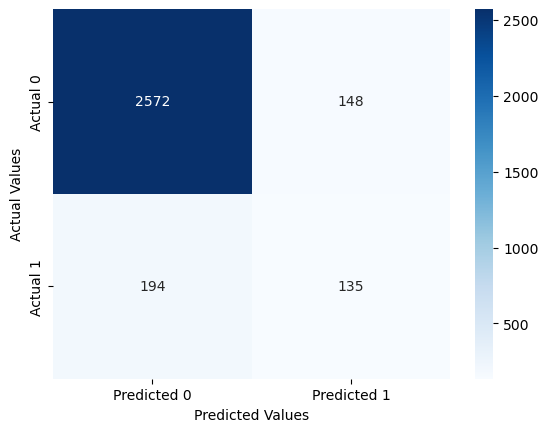

In [151]:
confusion_matrix_data(train,train.y_dum,logit_model,0.3)

Classification accuracy = 88.7%
Precision = 48.8%
TPR or Recall = 46.4%
FNR = 53.6%
FPR = 6.0%
ROC-AUC = 76.3%


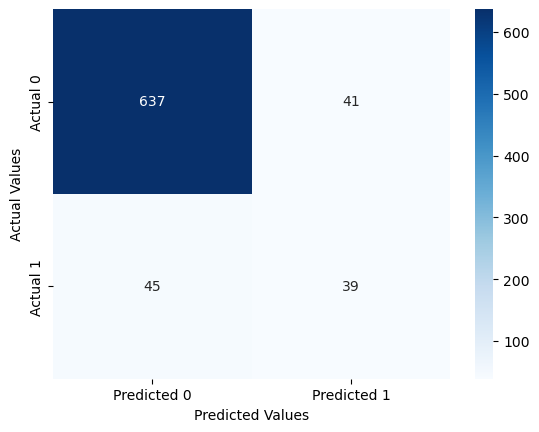

In [152]:
confusion_matrix_data(test,test.y_dum,logit_model,0.3)

### Optimizing the final model through SMOTE
*By Yide Cui*

In [153]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTENC

Text(0.5, 1.0, 'Has the client subscribed a term deposit?')

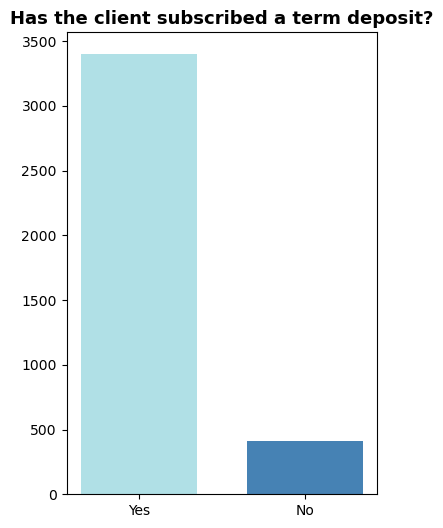

In [154]:
Subscription = {'Yes':3398, 'No':413}
YN = list(Subscription.keys())
Counts = list(Subscription.values())
  
fig = plt.figure(figsize = (4, 6))

# creating the bar plot
plt.bar(YN, Counts, color = ['powderblue', 'steelblue'], width = 0.7)
 
plt.title("Has the client subscribed a term deposit?",fontdict={'fontsize': '13', 'fontweight' : 'bold'})

Text(0.5, 1.0, 'Has the client subscribed a term deposit? (SMOTE)')

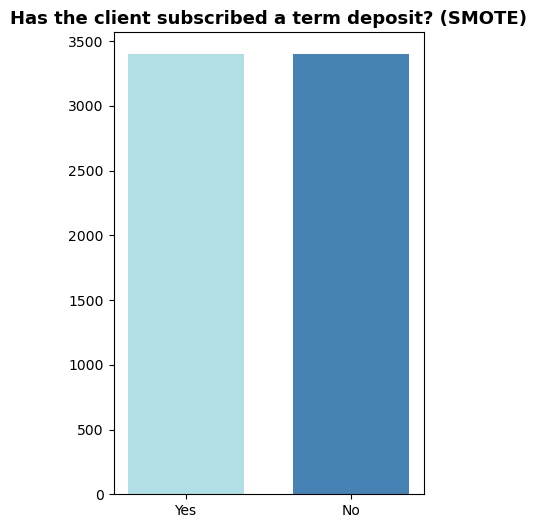

In [155]:
Subscription = {'Yes':3398, 'No':3398}
YN = list(Subscription.keys())
Counts = list(Subscription.values())
  
fig = plt.figure(figsize = (4, 6))

# creating the bar plot
plt.bar(YN, Counts, color = ['powderblue', 'steelblue'], width = 0.7)
 
plt.title("Has the client subscribed a term deposit? (SMOTE)",fontdict={'fontsize': '13', 'fontweight' : 'bold'})

In [156]:
data

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,...,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,poutcome_modified,y_dum,poutcome_success
0,30,Employed,married,Primary,yes,no,cellular,may,fri,487,...,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,failure,0,NaN
1,39,Employed,single,Secondary,no,no,telephone,may,fri,346,...,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,failure,0,NaN
2,25,Employed,married,Secondary,yes,no,telephone,jun,wed,227,...,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,failure,0,NaN
4,47,Employed,married,Tertiary,yes,no,cellular,nov,mon,58,...,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,failure,0,NaN
5,32,Employed,single,Tertiary,no,no,cellular,sep,thu,128,...,2,failure,-1.1,94.199,-37.5,0.884,4963.6,failure,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,Employed,married,Primary,yes,yes,cellular,jul,thu,53,...,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,failure,0,NaN
4115,39,Employed,married,Secondary,yes,no,telephone,jul,fri,219,...,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,failure,0,NaN
4116,27,Unemployed,single,Secondary,no,no,cellular,may,mon,64,...,1,failure,-1.8,92.893,-46.2,1.354,5099.1,failure,0,0.0
4117,58,Employed,married,Secondary,no,no,cellular,aug,fri,528,...,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,failure,0,NaN


In [157]:
data.drop(['poutcome_success'], axis=1, inplace = True)

In [158]:
X=data.iloc[:,:20]
y=data.iloc[:,20]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [159]:
X

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,poutcome_modified
0,30,Employed,married,Primary,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,failure
1,39,Employed,single,Secondary,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,failure
2,25,Employed,married,Secondary,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,failure
4,47,Employed,married,Tertiary,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,failure
5,32,Employed,single,Tertiary,no,no,cellular,sep,thu,128,3,999,2,failure,-1.1,94.199,-37.5,0.884,4963.6,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,Employed,married,Primary,yes,yes,cellular,jul,thu,53,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,failure
4115,39,Employed,married,Secondary,yes,no,telephone,jul,fri,219,1,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,failure
4116,27,Unemployed,single,Secondary,no,no,cellular,may,mon,64,2,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,failure
4117,58,Employed,married,Secondary,no,no,cellular,aug,fri,528,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,failure


In [160]:
## Balancing the train data
sm_nc = SMOTENC(categorical_features=[1,2,3,4,5,6,7,8,13,19], random_state=20)
X_train_res, y_train_res = sm_nc.fit_resample(X_train, y_train)

Y = pd.DataFrame(y_train_res, columns=["y_dum"])
train_smote = pd.concat([X_train_res, Y], axis = 1) 
train_smote = train_smote.reindex(columns=["age", "job", "marital", "education", "housing", "loan", "contact", "month", 'day_of_week', "duration", "campaign", "pdays", "previous", "poutcome", "emp_var_rate", "cons_price_idx", "cons_conf_idx","euribor3m", "nr_employed", "poutcome_modified", "y_dum"])
train_smote.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,poutcome_modified,y_dum
0,32,Unemployed,single,Tertiary,no,no,telephone,may,fri,21,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,failure,0
1,51,Employed,married,Secondary,yes,no,telephone,jun,mon,81,...,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,failure,0
2,31,Unemployed,single,Tertiary,yes,no,cellular,jul,tue,309,...,6,3,success,-1.7,94.215,-40.3,0.835,4991.6,success,1
3,26,Employed,married,Primary,yes,no,telephone,jun,wed,71,...,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,failure,0
4,31,Employed,single,Primary,no,no,cellular,jul,wed,1432,...,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,failure,0


## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.